<b>Created by:</b> Cristiana Principato

<b>Date:</b> 04/30/2020

<b>Description:</b> Test which of two presentations does a better job at selling. USE PERMUTATION TEST

<b>Input:</b> csv file

<b>Output:</b> 


In [136]:
import pandas as pd
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt

In [137]:
web_data = pd.read_csv('web_page_data.csv')

In [138]:
web_data_pageA = web_data[web_data['Page']=='Page A']
web_data_pageB = web_data[web_data['Page']=='Page B']

### Visualize the results


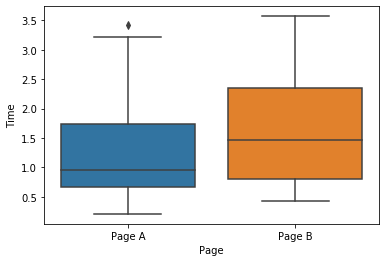

In [139]:
ax = sns.boxplot(x="Page", y="Time", data=web_data)

In [140]:
mean_time_pageA = web_data_pageA.Time.mean()
mean_time_pageB = web_data_pageB.Time.mean()

In [141]:
difference_in_means = mean_time_pageB - mean_time_pageA

In [142]:
difference_in_means

0.35666666666666713

### Is this difference statistically significant?
permutation_test:
1. Mix the data, such that n = n1 + n2
2. Randomly create two new sample
3.  check the difference in time

Let's start with the first step: Create two random samples
For our random sampling problem, we needed:
1. A specified sample size
2. A specified number of samples
3. Sampling without replacement
4. A specified inclusion probability of each element’s inclusion in a given sample

In [143]:
sample_size_A = len(web_data_pageA)
sample_size_B = len(web_data_pageB)
print('sample size A =', sample_size_A, 'sample size B =', sample_size_B)

sample size A = 21 sample size B = 15


In [144]:
def create_random_sample(size_group_1: int, replace: bool, data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    random_sample_group_1 = data.sample(n=size_group_1, replace=replace)
    random_sample_group_2 = data[~data.isin(random_sample_group_1)].dropna()
    return random_sample_group_1, random_sample_group_2

In [145]:
def permutation_metric(size_group_1: int, replace: bool, data: pd.DataFrame, metric: str) -> (float, float):
    random_sample_group_1, random_sample_group_2 = create_random_sample(size_group_1, replace, data)
    mean_group_1 = random_sample_group_1[metric].mean()
    mean_group_2 = random_sample_group_2[metric].mean()
    return mean_group_1, mean_group_2

In [146]:
def create_metric_distribution(size_group_1: int, replace: bool, data: pd.DataFrame, metric: str, iteration: int) -> list:
    metric_list = []
    
    for _ in range(1, iteration):
        mean_group_1, mean_group_2 = permutation_metric(size_group_1, replace, data, metric)
        difference_mean = mean_group_2 - mean_group_1
        metric_list.append(difference_mean)
    return metric_list

In [147]:
metric_list = create_metric_distribution(size_group_1=sample_size_A, 
                                         replace=False,
                                         data=web_data, 
                                         metric='Time', 
                                         iteration=10000)

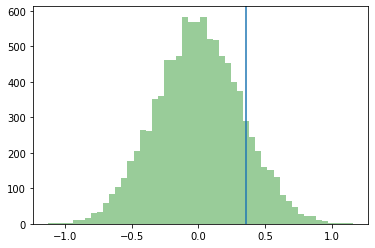

In [148]:
sns.distplot(metric_list, kde=False, color="g")
plt.axvline(difference_in_means)

# Is it statistically significant?

In [149]:
alpha = 0.05
confidence_level = 1 - alpha 

Calculate the p_value, the probability to get a result at least as extreme as the one we see.

Integral of the curve from `difference_in_means` to minus infinity. 

the sample space is discrete and is all positive integers. Well, then you simply count the occurrences and divide by the total number of events to get your estimate for the probabilities.

`metric_list` sum only the value less than `difference_in_means`

In [150]:
import scipy.stats
kde = scipy.stats.gaussian_kde(metric_list)

To get the probability of an observation in some interval:

In [151]:
p_value = kde.integrate_box_1d(difference_in_means, max(metric_list))

## Finally compare p_value to alpha

In [152]:
print('p value', p_value, 'alpha', alpha)

p value 0.13675475350374844 alpha 0.05


The observed difference in mean is well between the range of the null hypothesis

# Calculate confidence interval
Sampling with replacement

In [160]:
def calculate_metric(size_1: int, size_2:int, data: pd.DataFrame, metric_variable: str) -> (float, float):
    random_sample_group_1 = data.sample(n=size_1, replace=True)
    random_sample_group_2 = data.sample(n=size_2, replace=True)

    mean_group_1 = random_sample_group_1[metric_variable].mean()
    mean_group_2 = random_sample_group_2[metric_variable].mean()
    
    return mean_group_1, mean_group_2

In [161]:
def bootstrap_metric(size_1: int, size_2:int, data: pd.DataFrame, metric_variable: str) -> list:
    
    difference_list = []
    
    for _ in range(1, 10000):
        mean_group_1, mean_group_2 = calculate_metric(size_1, size_2, data, metric_variable)
        difference = mean_group_2 - mean_group_1
        difference_list.append(difference)
    
    return difference_list

In [162]:
def calculate_confidence_interval(size_1: int, size_2:int, data: pd.DataFrame, metric_variable: str, percentage_ci: float) -> (float, float):
    difference_list = bootstrap_metric(size_1, size_2, data, metric_variable)
    sorted_list_difference = sorted(difference_list)
    trim = (percentage_ci * len(sorted_list_difference)) // 100
    lower_bound = sorted_list_difference[trim]
    highest_bound = sorted_list_difference[-trim]
    print('trim =', trim, 'lower_bound', lower_bound, 'highest_bound', highest_bound)
    return sorted_list_difference, lower_bound, highest_bound


In [163]:
sorted_list_difference, lower_bound, highest_bound = calculate_confidence_interval(size_1=21, size_2=15, data=web_data, metric_variable='Time', 
                              percentage_ci=5)


trim = 499 lower_bound -0.5060952380952388 highest_bound 0.5142857142857142


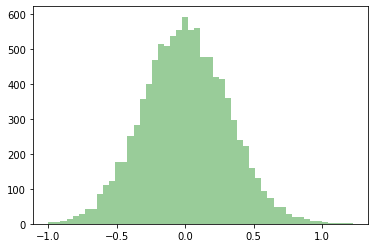

In [164]:
sns.distplot(sorted_list_difference, kde=False, color="g")

In [165]:
lower_bound, highest_bound

(-0.5060952380952388, 0.5142857142857142)

In [159]:
sorted_list_difference[499]

(1.0885714285714285, 1.7573333333333332)